In [1]:
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
import pathlib
from IPython.display import clear_output
from datetime import datetime
from sklearn.metrics import mean_squared_error
import numpy as np

mse = tf.keras.losses.MeanSquaredError()

AUTOTUNE = tf.data.AUTOTUNE

2023-11-02 04:57:55.751709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 04:57:56.921495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-125ycej3
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-125ycej3
  Resolved https://github.com/tensorflow/examples.git to commit d639fe4b394c391dfdf6d00171cfa916a7fc1175
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1698779193.1223017319550583858672544386243344910876866777461-py3-none-any.whl size=301582 sha256=99d08c251fcc1f1e6a81fbdb326101369745d1a45ad7a82d18863c1d36d512f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-nigg_xt_/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-11-02 04:58:06.952916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 04:58:07.044722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 04:58:07.045651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
def load_img(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  sar_image = image[:, w:, :]
  opt_image = image[:, :w, :]

  # Convert both images to float32 tensors
  sar_image = tf.cast(sar_image, tf.float32)
  opt_image = tf.cast(opt_image, tf.float32)
    
  return sar_image, opt_image

In [7]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image


In [8]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [9]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image


In [10]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image


In [11]:
def preprocess_image_train(image_file):
  input_image, real_image = load_img(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [12]:
def preprocess_image_test(image_file):
  input_image, real_image = load_img(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [13]:
train_path = pathlib.Path('/hdd/Datasets/sar2opt_raw_data/train')
test_path = pathlib.Path('/hdd/Datasets/sar2opt_raw_data/test')
train_filenames = tf.constant([os.path.join(train_path, fname) for fname in os.listdir(train_path)])
test_filenames = tf.constant([os.path.join(test_path, fname) for fname in os.listdir(test_path)])
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames))
test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames))

2023-11-02 04:58:22.733663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 04:58:22.734662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 04:58:22.735127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [14]:
train_dataset = train_dataset.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).batch(
    BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test_dataset.cache().map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).batch(
    BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
sample_sar, sample_opt = next(iter(train_dataset))

2023-11-02 04:58:34.796758: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


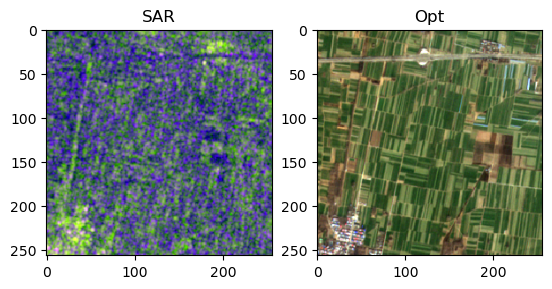

In [16]:
plt.subplot(121)
plt.title('SAR')
plt.imshow(sample_sar[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Opt')
plt.imshow(sample_opt[0] * 0.5 + 0.5)


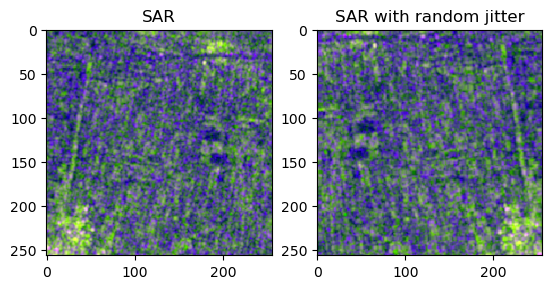

In [17]:
plt.subplot(121)
plt.title('SAR')
plt.imshow(sample_sar[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('SAR with random jitter')
sar, _ = random_jitter(sample_sar[0] * 0.5 + 0.5, sample_opt[0] * 0.5 + 0.5)
plt.imshow(sar)


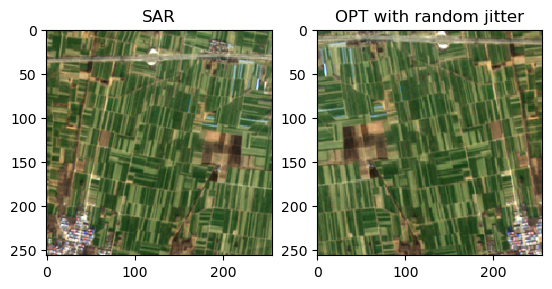

In [18]:
plt.subplot(121)
plt.title('SAR')
plt.imshow(sample_opt[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('OPT with random jitter')
_, opt = random_jitter(sample_sar[0] * 0.5 + 0.5, sample_opt[0] * 0.5 + 0.5)
plt.imshow(opt)


In [19]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)


2023-11-02 04:58:53.105458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


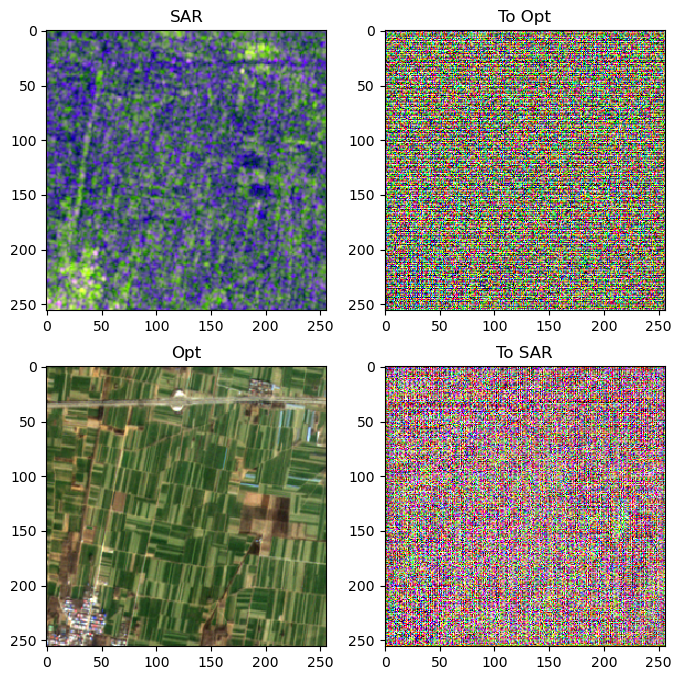

In [20]:
to_opt = generator_g(sample_sar)
to_sar = generator_f(sample_opt)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_sar, to_opt, sample_opt, to_sar]
title = ['SAR', 'To Opt', 'Opt', 'To SAR']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()


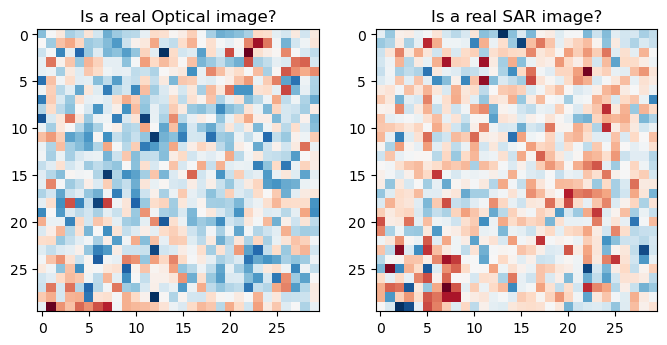

In [21]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real Optical image?')
plt.imshow(discriminator_y(sample_sar)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real SAR image?')
plt.imshow(discriminator_x(sample_opt)[0, ..., -1], cmap='RdBu_r')

plt.show()


In [22]:
LAMBDA = 10

In [23]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [25]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [26]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [27]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [28]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [36]:
checkpoint_path = "sar2opt/s_cyclegan/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_path, "ckpt")

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


Latest checkpoint restored!!


In [30]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [31]:
log_dir="sar2opt/s_cyclegan/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

In [32]:
@tf.function
def train_step(real_x, real_y, step):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y) + mse(real_y, fake_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x) + mse(real_x, fake_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_g_total_loss', total_gen_g_loss, step)
    tf.summary.scalar('gen_g_loss', gen_g_loss, step)
    tf.summary.scalar('total_cycle_loss', total_cycle_loss, step)
    tf.summary.scalar('disc_x_loss', disc_x_loss, step)
    tf.summary.scalar('disc_y_loss', disc_y_loss, step)


In [33]:
%load_ext tensorboard
%tensorboard --logdir={log_dir} --host=0.0.0.0

In [34]:
EPOCHS = 10

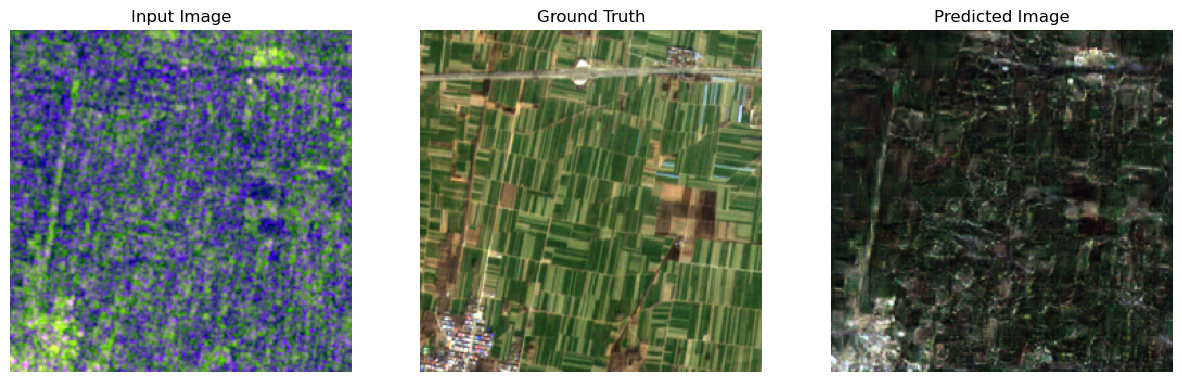

Saving checkpoint for epoch 3 at sar2opt/s_cyclegan/training_checkpoints/ckpt
Time taken for epoch 3 is 13228.658272504807 sec

.....

KeyboardInterrupt: 

In [35]:
tf.config.run_functions_eagerly(True)

for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_dataset)):
    train_step(image_x, image_y, epoch)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_sar, sample_opt)

  #if (epoch + 1) % 5 == 0: 
  ckpt.save(file_prefix=checkpoint_prefix)
  print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         checkpoint_prefix))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
import numpy as np
# Run the trained model on the test dataset
for sar, opt in test_sar_tiles.take(5):
  generate_images(generator_g, sar, opt)
